In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


print("Using TensorFlow version:", tf.__version__)

Using TensorFlow version: 2.18.0


## 1. Chargement du dataset

In [ ]:
# # Chemin vers le dossier qui contient les deux sous-dossiers : 'good' et 'defect'
# DATA_DIR = "screw_dataset"  # À adapter

# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)

# # Charger toutes les images d'un seul tenant
# dataset = image_dataset_from_directory(
#     DATA_DIR,
#     labels='inferred',
#     label_mode='categorical',  # Pour un problème multi-classes, ici on suppose 2 classes (good, defect)
#     batch_size=BATCH_SIZE,
#     image_size=IMG_SIZE,
#     shuffle=True  # Mélange les données
# )

# # Afficher les classes détectées
# class_names = dataset.class_names
# print("Classes détectées :", class_names)

# # Optionnel : Normalisation et mise en cache
# AUTOTUNE = tf.data.AUTOTUNE
# def preprocess(image, label):
#     image = tf.cast(image, tf.float32) / 255.0  # Normalisation simple
#     return image, label

# dataset = dataset.map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)

Found 1152 files belonging to 2 classes.
Classes détectées : ['bad', 'good']


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Chemin vers le dossier contenant 'good' et 'bad'
DATA_DIR = "screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Obtenir la liste des noms de fichiers et leurs dossiers d'origine
file_paths = []
folders = []

for class_name in ['bad', 'good']:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(class_dir, img_name))
            folders.append(class_name)

# Chargement des images
print("Chargement des images...")
dataset = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',  # Classification binaire
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Extraction des images et labels
all_images = []
all_labels = []
for images, labels in dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X = np.concatenate(all_images, axis=0) / 255.0  # Normalisation 
y = np.concatenate(all_labels, axis=0)

# Affichage des statistiques de base
print(f"Nombre total d'images: {X.shape[0]}")
print(f"Images 'bad' (label 0): {np.sum(y == 0)}")
print(f"Images 'good' (label 1): {np.sum(y == 1)}")

# Mélange des données
indices = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

# On mélange aussi les chemins de fichiers de la même façon
file_paths = np.array(file_paths)
folders = np.array(folders)
file_paths_shuffled = file_paths[indices]
folders_shuffled = folders[indices]

# Affichage des 10 premiers échantillons après mélange avec nom de fichier et dossier
print("\nPremiers échantillons après mélange:")
print("| N° | Nom de l'image                | Dossier d'origine | Label |")
print("|----|--------------------------------|-------------------|-------|")
for i in range(10):
    img_name = os.path.basename(file_paths_shuffled[i])
    folder = folders_shuffled[i]
    label = int(y_shuffled[i])
    print(f"| {i+1:2d} | {img_name:30s} | {folder:15s} | {label}     |")

# Division train/validation/test (70/15/15)
X_train, X_temp, y_train, y_temp, paths_train, paths_temp, folders_train, folders_temp = train_test_split(
    X_shuffled, y_shuffled, file_paths_shuffled, folders_shuffled, train_size=0.7, stratify=y_shuffled, random_state=42
)

X_val, X_test, y_val, y_test, paths_val, paths_test, folders_val, folders_test = train_test_split(
    X_temp, y_temp, paths_temp, folders_temp, train_size=0.5, stratify=y_temp, random_state=42
)

# Statistiques des ensembles
print(f"\nEnsemble d'entraînement: {X_train.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")

print(f"\nEnsemble de validation: {X_val.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_val == 0)} ({np.mean(y_val == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_val == 1)} ({np.mean(y_val == 1)*100:.1f}%)")

print(f"\nEnsemble de test: {X_test.shape[0]} images")
print(f"  - Bad (0): {np.sum(y_test == 0)} ({np.mean(y_test == 0)*100:.1f}%)")
print(f"  - Good (1): {np.sum(y_test == 1)} ({np.mean(y_test == 1)*100:.1f}%)")

# Création des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print("\nLes datasets sont prêts à être utilisés pour l'entraînement!")

Chargement des images...
Found 1152 files belonging to 2 classes.
Nombre total d'images: 1152
Images 'bad' (label 0): 285
Images 'good' (label 1): 867

Premiers échantillons après mélange:
| N° | Nom de l'image                | Dossier d'origine | Label |
|----|--------------------------------|-------------------|-------|
|  1 | 020_png.rf.bc1d8a583bfdb217fac2f64731e9771e.jpg | bad             | 0     |
|  2 | 196_png.rf.7fe8531648ca4aada3540a77f0ed51f6.jpg | good            | 1     |
|  3 | 009_png.rf.4539849089ddf72abf868f1b866a0d09.jpg | good            | 1     |
|  4 | 006_png.rf.c13a364cc262b36d021c69ab2a8533dc.jpg | bad             | 0     |
|  5 | 010_png.rf.1b22cf6babd655ecd7b71eff26a6310b.jpg | good            | 1     |
|  6 | 010_png.rf.49e214452922e22b40fe37eae05704b0.jpg | bad             | 0     |
|  7 | 032_png.rf.f74158859e091821a14a89d777c86dfa.jpg | good            | 1     |
|  8 | 210_png.rf.2476a4242693cc1c0b22a415c208ff82.jpg | good            | 1     |
|  9 | 307_p

/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_25689/148269067.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y_shuffled[i])



Ensemble d'entraînement: 806 images
  - Bad (0): 199 (24.7%)
  - Good (1): 607 (75.3%)

Ensemble de validation: 173 images
  - Bad (0): 43 (24.9%)
  - Good (1): 130 (75.1%)

Ensemble de test: 173 images
  - Bad (0): 43 (24.9%)
  - Good (1): 130 (75.1%)

Les datasets sont prêts à être utilisés pour l'entraînement!


In [27]:
print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Type de X_train:", type(X_train))
print("Type de y_train:", type(y_train))
print("Premiers éléments de y_train:", y_train[:5])  # Affiche les 5 premiers labels

Forme de X_train: (806, 224, 224, 3)
Forme de y_train: (806, 1)
Type de X_train: <class 'numpy.ndarray'>
Type de y_train: <class 'numpy.ndarray'>
Premiers éléments de y_train: [[1.]
 [0.]
 [1.]
 [1.]
 [1.]]


## Data augmentation

Forme de X_train: (806, 224, 224, 3)
Forme de y_train: (806, 1)
Nombre d'images 'bad' avant augmentation: 199
Nombre d'images 'good' avant augmentation: 607


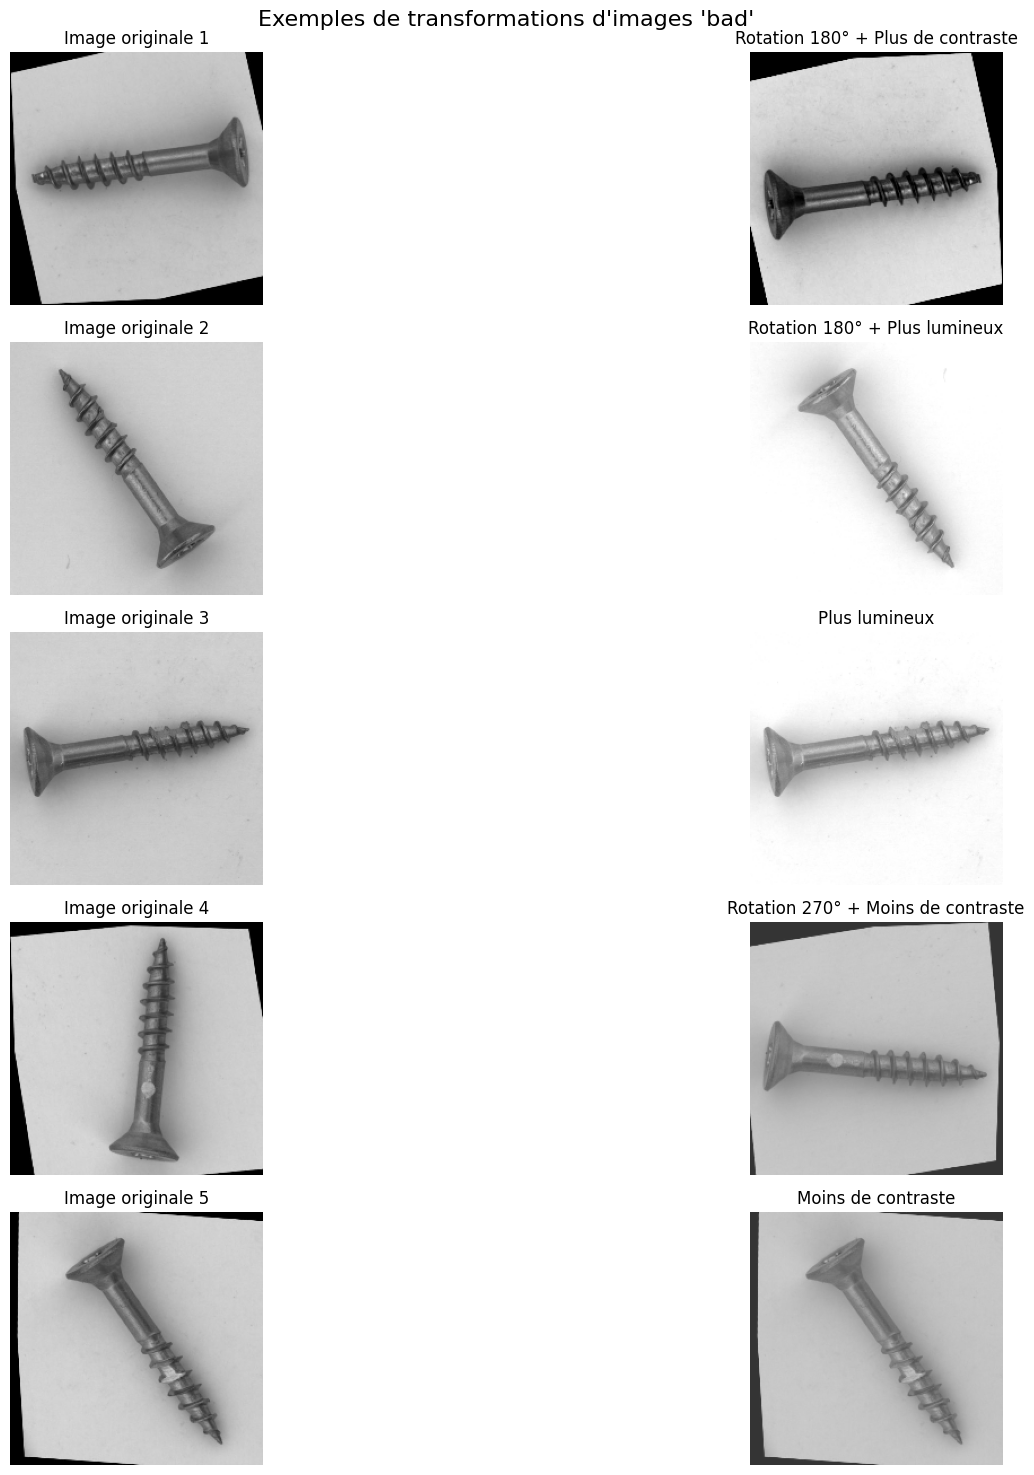


Utilisation des transformations:
Rotation 90°: 20 fois
Rotation 180°: 20 fois
Plus lumineux: 20 fois
Plus sombre: 20 fois
Moins de contraste: 20 fois
Perte de résolution: 20 fois
Saturation extrême: 20 fois
Rotation 90° + Plus lumineux: 20 fois
Rotation 90° + Plus sombre: 20 fois
Rotation 90° + Plus de contraste: 20 fois
Rotation 90° + Moins de contraste: 20 fois
Rotation 180° + Plus lumineux: 20 fois
Rotation 180° + Plus sombre: 20 fois
Rotation 180° + Plus de contraste: 20 fois
Rotation 180° + Moins de contraste: 20 fois
Rotation 270° + Plus lumineux: 20 fois
Rotation 270° + Plus sombre: 20 fois
Rotation 270° + Moins de contraste: 20 fois
Rotation 90° + Perte de résolution: 20 fois
Rotation 90° + Saturation extrême: 20 fois
Rotation 90° + Bruit gaussien: 20 fois
Rotation 180° + Perte de résolution: 20 fois
Rotation 270° + Perte de résolution: 20 fois
Rotation 270° + Saturation extrême: 20 fois
Rotation 270° + Bruit gaussien: 20 fois
Bruit gaussien: 19 fois
Rotation 270° + Plus de co

In [60]:
def rotate_image(image, angle_degrees):
    return tf.image.rot90(
        image, 
        k=int(round(angle_degrees / 90)) % 4
    )

def adjust_pixels(image, brightness_delta, contrast_factor):
    bright_image = tf.image.adjust_brightness(image, brightness_delta)
    adjusted_image = tf.image.adjust_contrast(bright_image, contrast_factor)
    return tf.clip_by_value(adjusted_image, 0.0, 1.0)

def degrade_quality(image, quality_level):
    if quality_level == 1:
        smaller = tf.image.resize(image, [112, 112])
        degraded = tf.image.resize(smaller, [224, 224])
        return degraded
    
    elif quality_level == 2:
        saturated = tf.image.adjust_saturation(image, 2.0)
        return saturated
    
    elif quality_level == 3:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
        noisy_img = image + noise
        return tf.clip_by_value(noisy_img, 0.0, 1.0)
    
    return image

def data_augmentation(X_train, y_train):
    # Vérifier la forme des données
    print("Forme de X_train:", X_train.shape)
    print("Forme de y_train:", y_train.shape)

    # Trouver les indices des images "bad" et "good"
    bad_indices = np.where(y_train[:, 0] == 0)[0]
    good_indices = np.where(y_train[:, 0] == 1)[0]
    
    X_bad = X_train[bad_indices]
    X_good = X_train[good_indices]

    print(f"Nombre d'images 'bad' avant augmentation: {len(X_bad)}")
    print(f"Nombre d'images 'good' avant augmentation: {len(X_good)}")

    # Définir les transformations
    def rotation_transforms():
        return [
            (lambda img: rotate_image(img, 90), "Rotation 90°"),
            (lambda img: rotate_image(img, 180), "Rotation 180°"),
            (lambda img: rotate_image(img, 270), "Rotation 270°")
        ]

    def pixel_transforms():
        return [
            (lambda img: adjust_pixels(img, 0.2, 1.0), "Plus lumineux"),
            (lambda img: adjust_pixels(img, -0.2, 1.0), "Plus sombre"),
            (lambda img: adjust_pixels(img, 0.0, 1.5), "Plus de contraste"),
            (lambda img: adjust_pixels(img, 0.0, 0.7), "Moins de contraste")
        ]

    def quality_transforms():
        return [
            (lambda img: degrade_quality(img, 1), "Perte de résolution"),
            (lambda img: degrade_quality(img, 2), "Saturation extrême"),
            (lambda img: degrade_quality(img, 3), "Bruit gaussien")
        ]

    def combo_transforms():
        combos = []
        rotations = rotation_transforms()
        pixels = pixel_transforms()
        qualities = quality_transforms()
        
        # Combinaisons rotation + pixel
        for rot in rotations:
            for pix in pixels:
                combos.append((
                    lambda img, r=rot[0], p=pix[0]: p(r(img)), 
                    f"{rot[1]} + {pix[1]}"
                ))
        
        # Combinaisons rotation + qualité
        for rot in rotations:
            for qual in qualities:
                combos.append((
                    lambda img, r=rot[0], q=qual[0]: q(r(img)), 
                    f"{rot[1]} + {qual[1]}"
                ))
        
        return combos

    # Collecter toutes les transformations
    all_transforms = (
        rotation_transforms() + 
        pixel_transforms() + 
        quality_transforms() + 
        combo_transforms()
    )

    # Générer les images augmentées
    X_bad_augmented = []
    y_bad_augmented = []
    
    # Suivre l'utilisation des transformations
    transform_counts = {t[1]: 0 for t in all_transforms}

    # Liste pour stocker les transformations utilisées
    used_transforms = []

    # Générer des augmentations jusqu'à atteindre le nombre d'images 'good'
    np.random.seed(42)
    remaining_count = len(X_good)
    
    while len(X_bad_augmented) < remaining_count:
        # Choisir une image source
        img_source = X_bad[len(X_bad_augmented) % len(X_bad)]
        
        # Créer une liste de transformations disponibles
        available_transforms = [
            t for t in all_transforms 
            if transform_counts[t[1]] < (remaining_count // len(all_transforms) + 1)
        ]
        
        # Réinitialiser si nécessaire
        if not available_transforms:
            transform_counts = {t[1]: 0 for t in all_transforms}
            available_transforms = all_transforms
        
        # Choisir une transformation
        transform, transform_name = random.choice(available_transforms)
        
        # Appliquer la transformation
        transformed_img = transform(img_source)
        
        # Ajouter l'image
        X_bad_augmented.append(transformed_img.numpy())
        y_bad_augmented.append(0)
        
        # Stocker la transformation
        used_transforms.append(transform_name)
        
        # Mettre à jour le compteur
        transform_counts[transform_name] += 1

    # Tronquer pour correspondre exactement au nombre d'images 'good'
    X_bad_augmented = X_bad_augmented[:len(X_good)]
    y_bad_augmented = y_bad_augmented[:len(X_good)]
    used_transforms = used_transforms[:len(X_good)]

    # Convertir en arrays numpy
    X_bad_augmented = np.array(X_bad_augmented)
    y_bad_augmented = np.array(y_bad_augmented).reshape(-1, 1)

    # Visualiser les augmentations
    plt.figure(figsize=(20, 15))
    visualization_samples = list(zip(X_bad[:5], X_bad_augmented[:5], used_transforms[:5]))

    for i, (original, transformed, transform_type) in enumerate(visualization_samples):
        # Image originale
        plt.subplot(5, 2, i*2+1)
        plt.imshow(original)
        plt.title(f"Image originale {i+1}")
        plt.axis('off')
        
        # Image transformée
        plt.subplot(5, 2, i*2+2)
        plt.imshow(transformed)
        plt.title(transform_type)
        plt.axis('off')

    plt.suptitle("Exemples de transformations d'images 'bad'", fontsize=16)
    plt.tight_layout()
    plt.savefig('augmented_bad_images.png')
    plt.show()

    # Afficher les statistiques des transformations
    print("\nUtilisation des transformations:")
    for name, count in sorted(transform_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{name}: {count} fois")

    # Combiner avec les images "good"
    X_train_balanced = np.concatenate([X_good, X_bad_augmented])
    y_train_balanced = np.concatenate([
        y_train[good_indices], 
        y_bad_augmented
    ])

    # Mélanger le nouvel ensemble d'entraînement
    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    # Afficher les statistiques du nouvel ensemble équilibré
    print("\nStatistiques de l'ensemble d'entraînement équilibré:")
    print(f"Nombre total d'images: {len(X_train_balanced)}")
    print(f"Images 'bad' (0): {np.sum(y_train_balanced == 0)} ({np.sum(y_train_balanced == 0)/len(y_train_balanced)*100:.1f}%)")
    print(f"Images 'good' (1): {np.sum(y_train_balanced == 1)} ({np.sum(y_train_balanced == 1)/len(y_train_balanced)*100:.1f}%)")

    # Créer un nouveau dataset TensorFlow
    train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
    train_dataset_balanced = train_dataset_balanced.shuffle(buffer_size=len(X_train_balanced)).batch(BATCH_SIZE)

    return X_train_balanced, y_train_balanced, train_dataset_balanced

# Ajouter un point d'entrée pour l'exécution directe
if __name__ == "__main__":
    # Vérifier si les variables sont définies avant l'exécution
    try:
        X_train_balanced, y_train_balanced, train_dataset_balanced = data_augmentation(X_train, y_train)
    except NameError:
        print("Erreur : Les variables X_train et y_train doivent être définies avant l'appel de la fonction.")

## 2. Définition d'un modèle simple
On définit un modèle CNN

In [20]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

model.summary()

/Users/emmacoco/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,977,250 (22.80 MB)

 Trainable params: 5,977,250 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Entraînement du modèle

In [ ]:
EPOCHS = 1000  # Nombre d'époques d'entraînement

history = model.fit(
    dataset,                 # Entraînement ET test sur le même dataset
    epochs=EPOCHS,
    verbose=1
)

## 4. Évaluation sur le même dataset

In [ ]:
loss, accuracy = model.evaluate(dataset, verbose=0)
print(f"Loss sur le dataset complet : {loss:.4f}")
print(f"Accuracy sur le dataset complet : {accuracy:.4f}")